# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:

To cluster the similar reviews using algorithms like K-Means, Hierarchical clustring (Agglomerative Clustering) and Density based clustering (DBSCAN)

# [1] Reading data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

Additionally, since this is unsupervised learning, we won't be using the labels.

In [18]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn import datasets, neighbors
import gensim
from sklearn.cluster import KMeans
import scipy
from sklearn.preprocessing import normalize

In [19]:
con = sqlite3.connect('D:/Work/database.sqlite')
data = pd.read_sql_query('''select * from Reviews where Score != 3''', con)

In [20]:
def partition(x):
    if x < 3:
        return 'negative'
    else:
        return 'positive'

In [21]:
actual_score = data['Score']
posneg = actual_score.map(partition)
data['Score'] = posneg

sorted_data = data.sort_values('ProductId', axis=0, ascending= True, inplace= False,
                                        kind= 'quicksort', na_position='last')
final = sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=False)

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

final_ = final.sample(n=50000)

# [2] Data preprocessing

In [22]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

i=0;
for sent in final_['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        break;
    i += 1;
    
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [23]:

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final_['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
    
    
final_['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final_['CleanedText']=final_['CleanedText'].str.decode("utf-8")    

# [3] Clustering 

## [3.1] K Means

### [3.1.1.1 ] BoW

In [45]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final_["CleanedText"].values)

In [46]:
k = list(range(2,11)) # number of clusters

loss = []

for cluster in k:
    
    kmeans = KMeans(n_clusters = cluster, n_jobs = -1, verbose=1).fit(final_counts)
    loss.append(kmeans.inertia_)     

optimal_k = np.argmin(loss) + 2 # As argmin return the index of minimum loss.

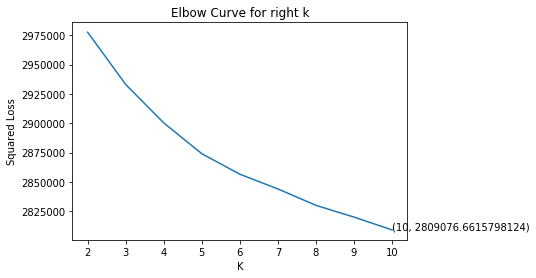

The optimal number of clusters is -  10
The loss for optimal cluster is -  2809076.6615798124


In [47]:
plt.plot(k, loss)
plt.title("Elbow Curve for right k")
plt.xlabel("K")
plt.ylabel("Squared Loss")
xy = (optimal_k, min(loss))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters is - ", optimal_k)
print ("The loss for optimal cluster is - ", min(loss))

In [48]:
model = KMeans(n_clusters = optimal_k, n_jobs = -1)
model.fit(final_counts)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [49]:
labeled_data = final_
labeled_data['cluster_label'] = model.labels_
#print(labeled_data[labeled_data['cluster_label']==7].head(3))

In [50]:
labeled_data.groupby(['cluster_label']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
cluster_label                                                                
0               6792       6792    6792         6792                  6792   
1               1568       1568    1568         1568                  1568   
2              29600      29600   29600        29600                 29600   
3                584        584     584          584                   584   
4               1582       1582    1582         1582                  1582   
5               2388       2388    2388         2388                  2388   
6               5865       5865    5865         5865                  5865   
7               1098       1098    1098         1098                  1098   
8                304        304     304          304                   304   
9                219        219     219          219                   219   

               HelpfulnessDenominator  Score   Time  Summary   Text  \
cluster_label                                                         
0                                6792   6792   6792     6792   6792   
1                                1568   1568   1568     1568   1568   
2                               29600  29600  29600    29600  29600   
3                                 584    584    584      584    584   
4                                1582   1582   1582     1582   1582   
5                                2388   2388   2388     2388   2388   
6                                5865   5865   5865     5865   5865   
7                                1098   1098   1098     1098   1098   
8                                 304    304    304      304    304   
9                                 219    219    219      219    219   

               CleanedText  
cluster_label               
0                     6792  
1                     1568  
2                    29600  
3                      584  
4                     1582  
5                     2388  
6                     5865  
7                     1098  
8                      304  
9                      219

The wordcloud for cluster 0


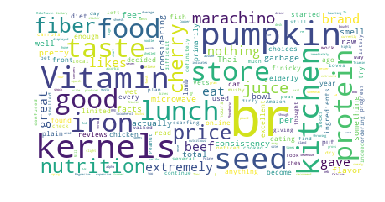

The wordcloud for cluster 1


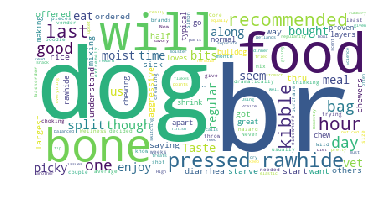

The wordcloud for cluster 2


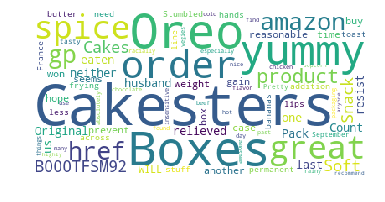

The wordcloud for cluster 3


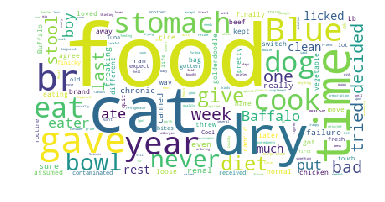

The wordcloud for cluster 4


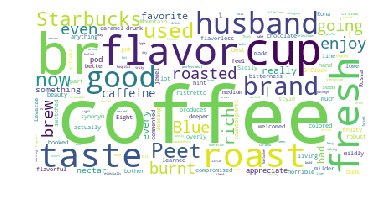

The wordcloud for cluster 5


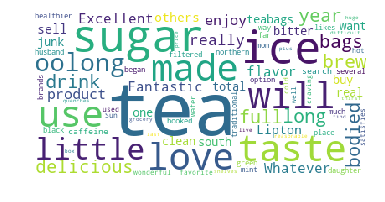

The wordcloud for cluster 6


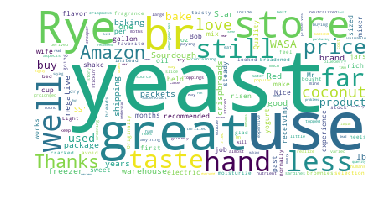

The wordcloud for cluster 7


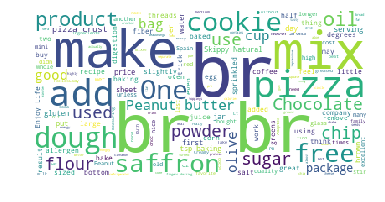

The wordcloud for cluster 8


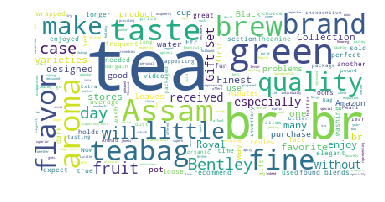

The wordcloud for cluster 9


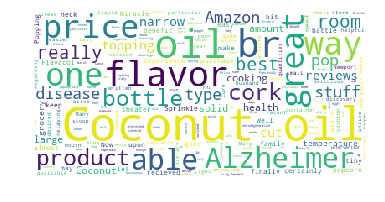

In [62]:
from wordcloud import WordCloud, STOPWORDS


for i in range(optimal_k):
    d_ = []
    for j in range(4):
        d1 = labeled_data.loc[labeled_data.groupby(['cluster_label']).groups[i][j]]['Text']
        d_.append(d1)
    wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(d_))
    print('The wordcloud for cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()       

** Summary **
* Cluster 0 important minerals and nutrients like the fiber content vitemins etc.
* Cluster 1 is somehow contains abou dogs and dog food and stuff.
* Cluster 2 cakes and other sweet stuff.
* Cluster 3 again seems to be about pets but more specific to cats.
* Cluster 4 appears to be created based on reviews that say about coffee.
* It appears cluster 5 has something like adjectives for drinks.
* Cluster 6, couldn't be said much about the cluster from the wordcloud thus formed.
* The cluster 7 is about the breads. The ingredients and types of breads etc. like pizza.
* Cluster 8 is most probably about the tea, it's types, it's flavour and place of origin.
* Cluster 9, the final cluster has certain kind of oils and diseases mentioned.

### [3.1.1.2] TF-IDF

In [24]:
tfidf_vect = TfidfVectorizer()
tfidf_data = tfidf_vect.fit_transform(final_['CleanedText'].values)

In [64]:
k = list(range(2,11)) # number of clusters

loss = []

for cluster in k:
    
    kmeans = KMeans(n_clusters = cluster, n_jobs = -1, verbose=1).fit(tfidf_data)
    loss.append(kmeans.inertia_)

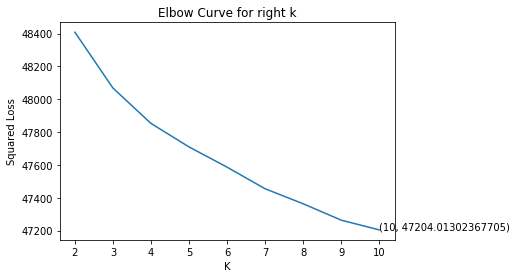

The optimal number of clusters is -  10
The loss for optimal cluster is -  47204.01302367705


In [65]:
optimal_k = np.argmin(loss) + 2 # As argmin return the index of minimum loss.
plt.plot(k, loss)
plt.title("Elbow Curve for right k")
plt.xlabel("K")
plt.ylabel("Squared Loss")
xy = (optimal_k, min(loss))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters is - ", optimal_k)
print ("The loss for optimal cluster is - ", min(loss))

In [66]:
model = KMeans(n_clusters = optimal_k, n_jobs = -1)
model.fit(tfidf_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [67]:
labeled_data = final_
labeled_data['cluster_label'] = model.labels_

In [68]:
labeled_data.groupby(['cluster_label']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
cluster_label                                                                
0               1651       1651    1651         1651                  1651   
1               3703       3703    3703         3703                  3703   
2               3047       3047    3047         3047                  3047   
3               1188       1188    1188         1188                  1188   
4               2523       2523    2523         2523                  2523   
5               1075       1075    1075         1075                  1075   
6               6952       6952    6952         6952                  6952   
7              19395      19395   19395        19395                 19395   
8               2290       2290    2290         2290                  2290   
9               8176       8176    8176         8176                  8176   

               HelpfulnessDenominator  Score   Time  Summary   Text  \
cluster_label                                                         
0                                1651   1651   1651     1651   1651   
1                                3703   3703   3703     3703   3703   
2                                3047   3047   3047     3047   3047   
3                                1188   1188   1188     1188   1188   
4                                2523   2523   2523     2523   2523   
5                                1075   1075   1075     1075   1075   
6                                6952   6952   6952     6952   6952   
7                               19395  19395  19395    19395  19395   
8                                2290   2290   2290     2290   2290   
9                                8176   8176   8176     8176   8176   

               CleanedText  
cluster_label               
0                     1651  
1                     3703  
2                     3047  
3                     1188  
4                     2523  
5                     1075  
6                     6952  
7                    19395  
8                     2290  
9                     8176

The wordcloud for cluster 0


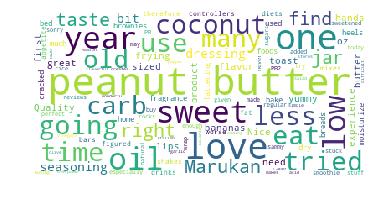

The wordcloud for cluster 1


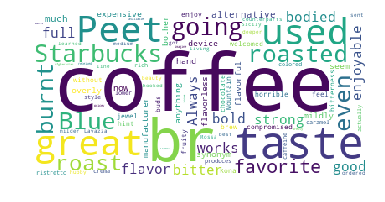

The wordcloud for cluster 2


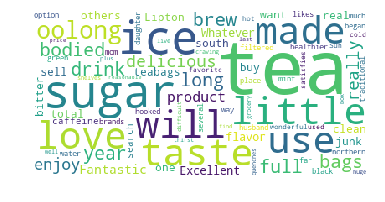

The wordcloud for cluster 3


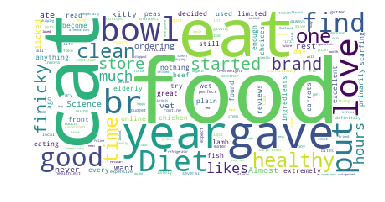

The wordcloud for cluster 4


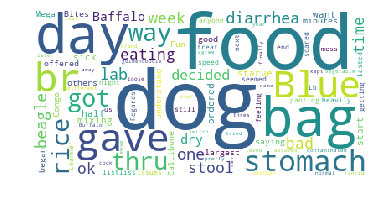

The wordcloud for cluster 5


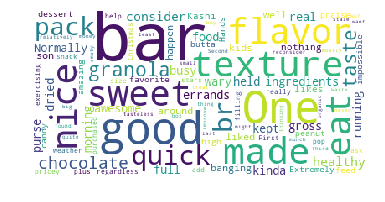

The wordcloud for cluster 6


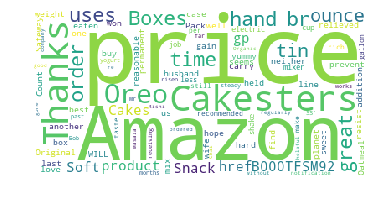

The wordcloud for cluster 7


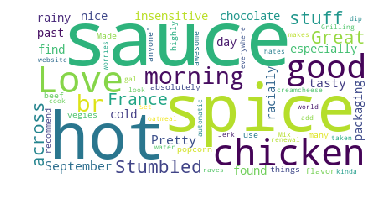

The wordcloud for cluster 8


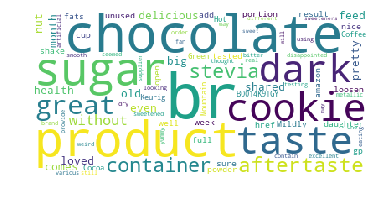

The wordcloud for cluster 9


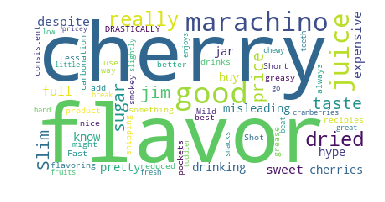

In [69]:
from wordcloud import WordCloud, STOPWORDS


for i in range(optimal_k):
    d_ = []
    for j in range(4):
        d1 = labeled_data.loc[labeled_data.groupby(['cluster_label']).groups[i][j]]['Text']
        d_.append(d1)
    wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(d_))
    print('The wordcloud for cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()       

** Summary **
* Cluster 0 contains info about oils, their essence and carbohydrates etc.
* Cluster 1 is about coffee and related drinks.
* Cluster 2 is about tea, it's kinds, brands etc and other drinks and stuff.
* Cluster 3 cat food.
* Cluster 4 about pets, specifically dogs.
* Cluster 5 has something about sweet stuff and it's kind.
* In cluster 6 we have packed food, snacks etc.
* The cluster 7 contains reviews stating hot and spicy sauces etc.
* Cluster 8 has packed chocolates and cookie boxes etc.
* Cluster 9 has cherries and other sweet sort of stuff.

### [3.1.1.3] W2V

In [70]:
import gensim
list_of_sent=[]

for sent in final_['Text']:
    filtered_sentence=[]
    for word in sent.split():
        for cleaned_words in cleanpunc(word).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [71]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=200, workers=4)

In [72]:
w2v_words = list(w2v_model.wv.vocab)

#### [3.1.1.3.1] Average W2V

In [73]:
sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(200)
    cnt_words = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

C:\Users\chauh\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


(50000, 200)

In [74]:
k = list(range(2,11)) # number of clusters

loss = []

for cluster in k:
    
    kmeans = KMeans(n_clusters = cluster, n_jobs = -1, verbose=1).fit(sent_vectors)
    loss.append(kmeans.inertia_)

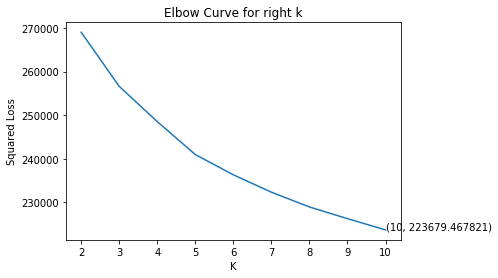

The optimal number of clusters is -  10
The loss for optimal cluster is -  223679.467821


In [75]:
optimal_k = np.argmin(loss) + 2 # As argmin return the index of minimum loss.
plt.plot(k, loss)
plt.title("Elbow Curve for right k")
plt.xlabel("K")
plt.ylabel("Squared Loss")
xy = (optimal_k, min(loss))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters is - ", optimal_k)
print ("The loss for optimal cluster is - ", min(loss))

In [76]:
model = KMeans(n_clusters = optimal_k, n_jobs = -1)
model.fit(sent_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [77]:
labeled_data = final_
labeled_data['cluster_label'] = model.labels_

In [78]:
labeled_data.groupby(['cluster_label']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
cluster_label                                                               
0              4109       4109    4109         4109                  4109   
1              4941       4941    4941         4941                  4941   
2              7942       7942    7942         7942                  7942   
3              3910       3910    3910         3910                  3910   
4              5670       5670    5670         5670                  5670   
5              4093       4093    4093         4093                  4093   
6              4550       4550    4550         4550                  4550   
7              6994       6994    6994         6994                  6994   
8              4139       4139    4139         4139                  4139   
9              3652       3652    3652         3652                  3652   

               HelpfulnessDenominator  Score  Time  Summary  Text  CleanedText  
cluster_label                                                                   
0                                4109   4109  4109     4109  4109         4109  
1                                4941   4941  4941     4941  4941         4941  
2                                7942   7942  7942     7942  7942         7942  
3                                3910   3910  3910     3910  3910         3910  
4                                5670   5670  5670     5670  5670         5670  
5                                4093   4093  4093     4093  4093         4093  
6                                4550   4550  4550     4550  4550         4550  
7                                6994   6994  6994     6994  6994         6994  
8                                4139   4139  4139     4139  4139         4139  
9                                3652   3652  3652     3652  3652         3652

The wordcloud for cluster 0


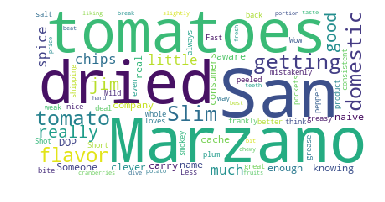

The wordcloud for cluster 1


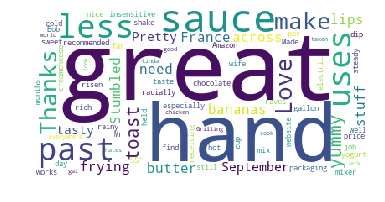

The wordcloud for cluster 2


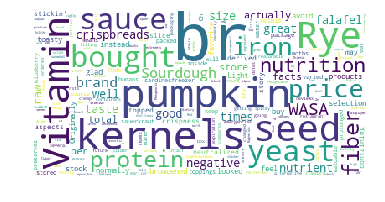

The wordcloud for cluster 3


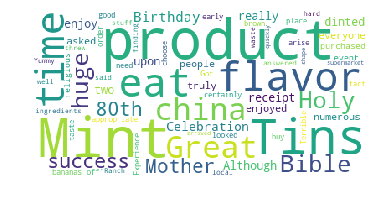

The wordcloud for cluster 4


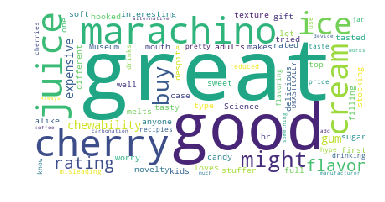

The wordcloud for cluster 5


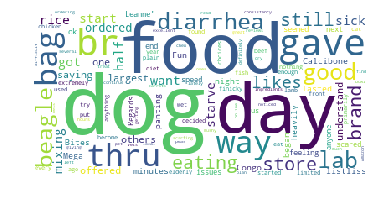

The wordcloud for cluster 6


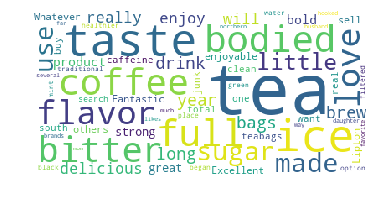

The wordcloud for cluster 7


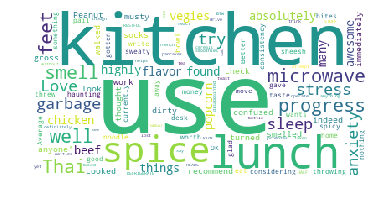

The wordcloud for cluster 8


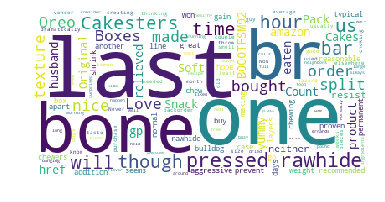

The wordcloud for cluster 9


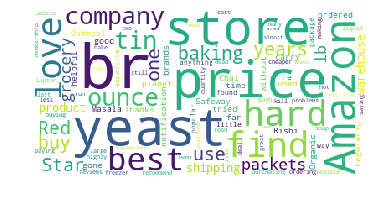

In [79]:
from wordcloud import WordCloud, STOPWORDS


for i in range(optimal_k):
    d_ = []
    for j in range(4):
        d1 = labeled_data.loc[labeled_data.groupby(['cluster_label']).groups[i][j]]['Text']
        d_.append(d1)
    wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(d_))
    print('The wordcloud for cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()       

** Summary **
* Cluster 0 seems it's about chips, other snacks and their flavors dominantly tomatoes.
* Cluster 1 seems like it has stuff that includes frying and something about sauces etc.
* Cluster 2 important minerals and nutrition like the fiber content vitemins etc.
* Cluster 3, couldn't be said much about this cluster with this ordcloud.
* Cluster 4 appears to be created based on reviews that say about cherries, juices, cream and other such stuff.
* It appears cluster 5 has something related to dog food and diseases.
* Cluster 6, is about beverages.
* The cluster 7 is about the stuff in the kitchen.
* Cluster 8 has cakes, cake boxes etc.
* Cluster 9 is about companies, stores at it appears.

#### [3.1.1.3.2] TF-IDF weighted W2V

In [81]:
tfidf_feat = tfidf_vect.get_feature_names()

tfidf_sent_vectors = []
row=0
for sent in list_of_sent: 
    sent_vec = np.zeros(200) 
    weight_sum = 0.0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_data[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)
print(tfidf_sent_vectors.shape)

C:\Users\chauh\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


(50000, 200)


In [82]:
k = list(range(2,11)) # number of clusters

loss = []

for cluster in k:
    
    kmeans = KMeans(n_clusters = cluster, n_jobs = -1, verbose=1).fit(tfidf_sent_vectors)
    loss.append(kmeans.inertia_)

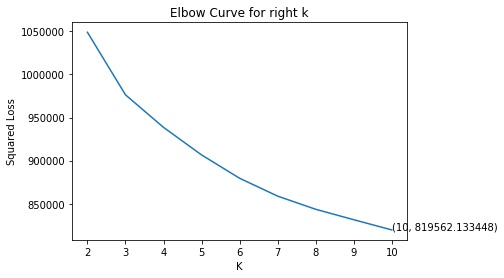

The optimal number of clusters is -  10
The loss for optimal cluster is -  819562.133448


In [83]:
optimal_k = np.argmin(loss) + 2 # As argmin return the index of minimum loss.
plt.plot(k, loss)
plt.title("Elbow Curve for right k")
plt.xlabel("K")
plt.ylabel("Squared Loss")
xy = (optimal_k, min(loss))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters is - ", optimal_k)
print ("The loss for optimal cluster is - ", min(loss))

In [84]:
model = KMeans(n_clusters = optimal_k, n_jobs = -1)
model.fit(tfidf_sent_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [85]:
labeled_data = final_
labeled_data['cluster_label'] = model.labels_

In [86]:
labeled_data.groupby(['cluster_label']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
cluster_label                                                                
0               2567       2567    2567         2567                  2567   
1               8385       8385    8385         8385                  8385   
2               4218       4218    4218         4218                  4218   
3               3627       3627    3627         3627                  3627   
4               4403       4403    4403         4403                  4403   
5               4313       4313    4313         4313                  4313   
6               1924       1924    1924         1924                  1924   
7               3840       3840    3840         3840                  3840   
8              11777      11777   11777        11777                 11777   
9               4946       4946    4946         4946                  4946   

               HelpfulnessDenominator  Score   Time  Summary   Text  \
cluster_label                                                         
0                                2567   2567   2567     2567   2567   
1                                8385   8385   8385     8385   8385   
2                                4218   4218   4218     4218   4218   
3                                3627   3627   3627     3627   3627   
4                                4403   4403   4403     4403   4403   
5                                4313   4313   4313     4313   4313   
6                                1924   1924   1924     1924   1924   
7                                3840   3840   3840     3840   3840   
8                               11777  11777  11777    11777  11777   
9                                4946   4946   4946     4946   4946   

               CleanedText  
cluster_label               
0                     2567  
1                     8385  
2                     4218  
3                     3627  
4                     4403  
5                     4313  
6                     1924  
7                     3840  
8                    11777  
9                     4946

The wordcloud for cluster 0


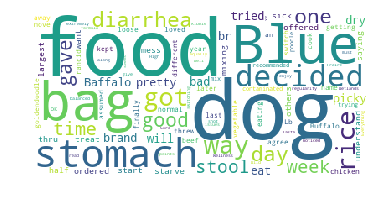

The wordcloud for cluster 1


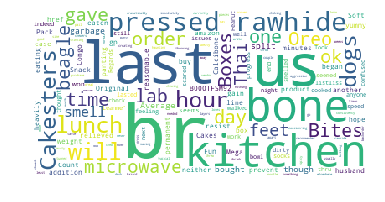

The wordcloud for cluster 2


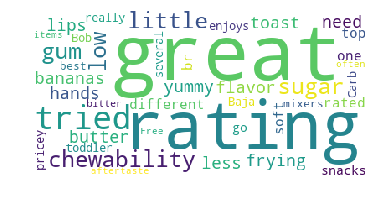

The wordcloud for cluster 3


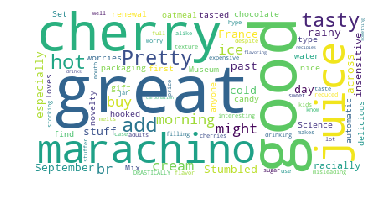

The wordcloud for cluster 4


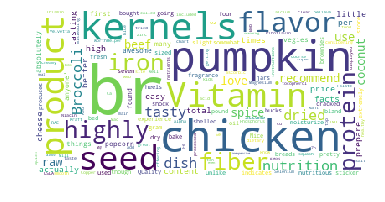

The wordcloud for cluster 5


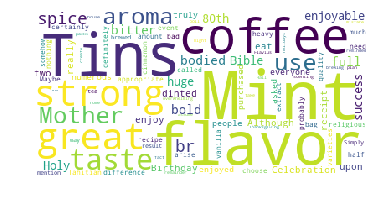

The wordcloud for cluster 6


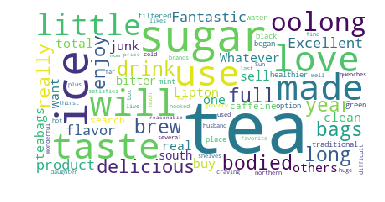

The wordcloud for cluster 7


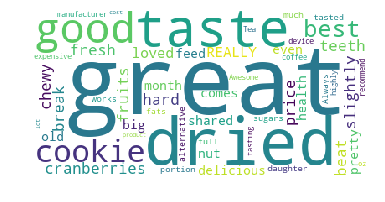

The wordcloud for cluster 8


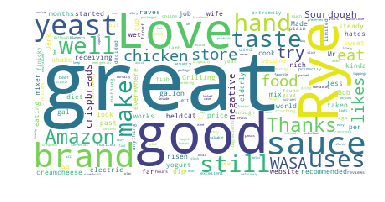

The wordcloud for cluster 9


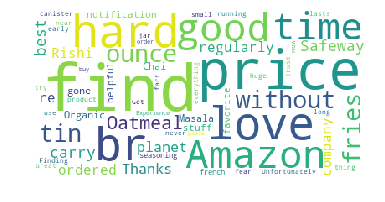

In [87]:
from wordcloud import WordCloud, STOPWORDS


for i in range(optimal_k):
    d_ = []
    for j in range(4):
        d1 = labeled_data.loc[labeled_data.groupby(['cluster_label']).groups[i][j]]['Text']
        d_.append(d1)
    wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(d_))
    print('The wordcloud for cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()       

** Summary **
* Cluster 0 is about dogs and diseases.
* Cluster 1 has kitchen stuff.
* Cluster 2 has chewable stuff like gums etc.
* Cluster 3 appears to be created based on reviews that say about cherries, juices, cream and other such stuff.
* Cluster 4 has protien, nutrition and carbohydrates stuff etc.
* It appears cluster 5 has reviews mentioning coffee and flavors.
* Cluster 6, has tea and flavors.
* The cluster 7 is about cookies and packed stuff, cranberries etc.
* Cluster 8 maybe about sauces and stores. Couldn't be said much about from the wordcloud.
* Cluster 9 has most probably noise points. Could not make out much from the wordcloud, the words don't appear to be similar.

## [3.2] Agglomerative clustering

In [88]:
from sklearn.cluster import AgglomerativeClustering

In [89]:
fin = final_.sample(n=5000)

### [3.2.1] BoW

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow_data = count_vect.fit_transform(fin['CleanedText'].values)
bow = normalize(bow_data)
print(bow_data.shape)
#type(bow_data)
#print(bow)

(5000, 9444)


# 2 clusters

In [91]:
labeled_data = fin

# k = 2
aggl = AgglomerativeClustering(n_clusters=2)
aggl.fit(bow.toarray())
labeled_data['Cluster_labels'] = aggl.labels_

In [92]:
labeled_data.groupby(['Cluster_labels']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
Cluster_labels                                                               
0               4663       4663    4663         4663                  4663   
1                337        337     337          337                   337   

                HelpfulnessDenominator  Score  Time  Summary  Text  \
Cluster_labels                                                       
0                                 4663   4663  4663     4663  4663   
1                                  337    337   337      337   337   

                CleanedText  cluster_label  
Cluster_labels                              
0                      4663           4663  
1                       337            337

The wordcloud for cluster 0


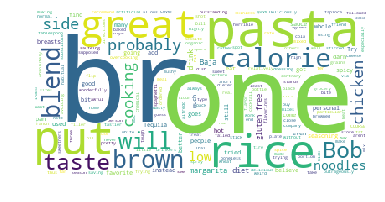

The wordcloud for cluster 1


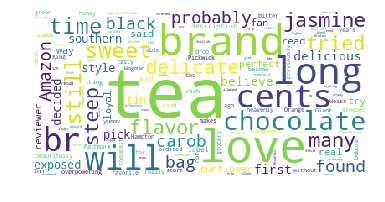

In [93]:
from wordcloud import WordCloud, STOPWORDS


for i in range(2):
    d_ = []
    for j in range(4):
        d1 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[i][j]]['Text']
        d_.append(d1)
    wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(d_))
    print('The wordcloud for cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()       

** Summary **
* Cluster 0 appears to contain reviews that contain eatable food items and stuff like that.
* On the other hand cluster 1 seems it has more of liquid items and reviews taking about the smell and essence of the products.

# 5 clusters

In [94]:
labeled_data = fin

# k = 5
aggl = AgglomerativeClustering(n_clusters=5)
aggl.fit(bow.toarray())
labeled_data['Cluster_labels'] = aggl.labels_

In [95]:
labeled_data.groupby(['Cluster_labels']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
Cluster_labels                                                               
0               3742       3742    3742         3742                  3742   
1                401        401     401          401                   401   
2                345        345     345          345                   345   
3                337        337     337          337                   337   
4                175        175     175          175                   175   

                HelpfulnessDenominator  Score  Time  Summary  Text  \
Cluster_labels                                                       
0                                 3742   3742  3742     3742  3742   
1                                  401    401   401      401   401   
2                                  345    345   345      345   345   
3                                  337    337   337      337   337   
4                                  175    175   175      175   175   

                CleanedText  cluster_label  
Cluster_labels                              
0                      3742           3742  
1                       401            401  
2                       345            345  
3                       337            337  
4                       175            175

The wordcloud for cluster 0


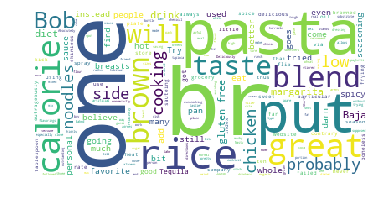

The wordcloud for cluster 1


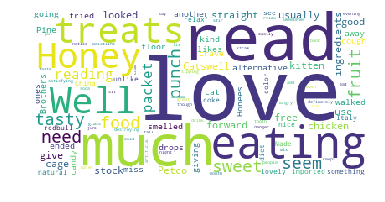

The wordcloud for cluster 2


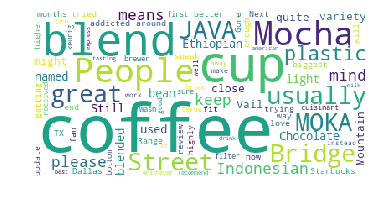

The wordcloud for cluster 3


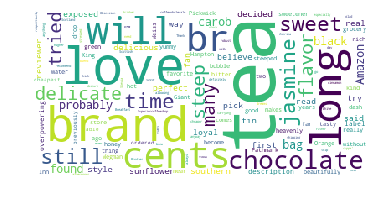

The wordcloud for cluster 4


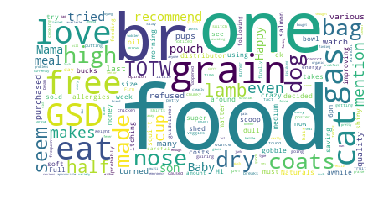

In [96]:
from wordcloud import WordCloud, STOPWORDS


for i in range(5):
    d_ = []
    for j in range(4):
        d1 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[i][j]]['Text']
        d_.append(d1)
    wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(d_))
    print('The wordcloud for cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()       

** Summary **
* Cluster 0 has normal food items like rice, pasta, chicken etc.
* Cluster 1 suggests color brown and cholocate nothing much other stuff to make out of it.
* Cluster 2 has reviews about coffee.
* Cluster 3 looks like it talks about tea, sweet stuff, chocolates and essence like jasmine.
* Cluster 4 appears to contains reviews that mention stuff about there pets(nose, their food etc).

## [3.2.2] TF-IDF

In [100]:
tfidf_vect = TfidfVectorizer()
tfidf_data = tfidf_vect.fit_transform(fin['CleanedText'].values)

# 2 clusters

In [101]:
labeled_data = fin

# k = 2

aggl = AgglomerativeClustering(n_clusters=2)
aggl.fit(tfidf_data.toarray())
labeled_data['Cluster_labels'] = aggl.labels_    

In [102]:
labeled_data.groupby(['Cluster_labels']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
Cluster_labels                                                               
0               4775       4775    4775         4775                  4775   
1                225        225     225          225                   225   

                HelpfulnessDenominator  Score  Time  Summary  Text  \
Cluster_labels                                                       
0                                 4775   4775  4775     4775  4775   
1                                  225    225   225      225   225   

                CleanedText  cluster_label  
Cluster_labels                              
0                      4775           4775  
1                       225            225

The wordcloud for cluster 0


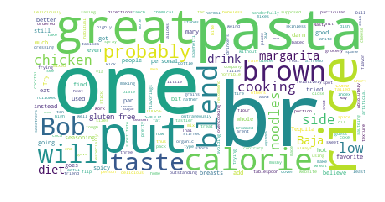

The wordcloud for cluster 1


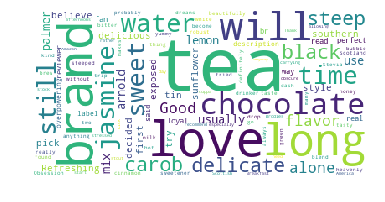

In [103]:
from wordcloud import WordCloud, STOPWORDS


for i in range(2):
    d_ = []
    for j in range(4):
        d1 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[i][j]]['Text']
        d_.append(d1)
    wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(d_))
    print('The wordcloud for cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()       

** Summary **
* Cluster 0 appears to contain reviews that contain eatable food items and stuff like that.
* On the other hand cluster 1 seems it has more of liquid items and reviews taking about the smell and essence of the products.

# 5 clusters

In [104]:
labeled_data = fin

# k = 5

aggl = AgglomerativeClustering(n_clusters=5)
aggl.fit(tfidf_data.toarray())
labeled_data['Cluster_labels'] = aggl.labels_    

In [105]:
labeled_data.groupby(['Cluster_labels']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
Cluster_labels                                                               
0               3971       3971    3971         3971                  3971   
1                324        324     324          324                   324   
2                411        411     411          411                   411   
3                225        225     225          225                   225   
4                 69         69      69           69                    69   

                HelpfulnessDenominator  Score  Time  Summary  Text  \
Cluster_labels                                                       
0                                 3971   3971  3971     3971  3971   
1                                  324    324   324      324   324   
2                                  411    411   411      411   411   
3                                  225    225   225      225   225   
4                                   69     69    69       69    69   

                CleanedText  cluster_label  
Cluster_labels                              
0                      3971           3971  
1                       324            324  
2                       411            411  
3                       225            225  
4                        69             69

The wordcloud for cluster 0


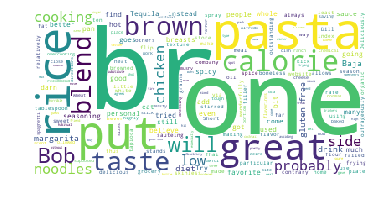

The wordcloud for cluster 1


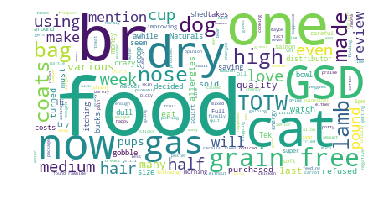

The wordcloud for cluster 2


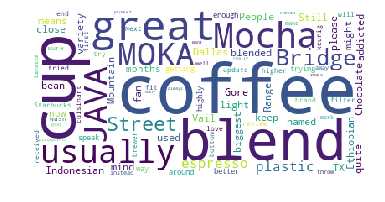

The wordcloud for cluster 3


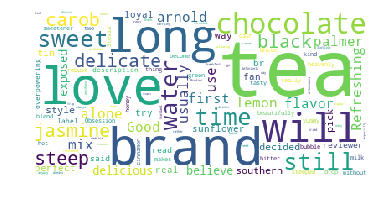

The wordcloud for cluster 4


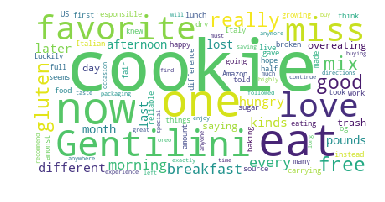

In [106]:
from wordcloud import WordCloud, STOPWORDS


for i in range(5):
    d_ = []
    for j in range(4):
        d1 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[i][j]]['Text']
        d_.append(d1)
    wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(d_))
    print('The wordcloud for cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()       

** Summary **
* Cluster 0 has normal food items like rice, pasta, chicken etc.
* Cluster 1 suggests pet food and pet stuff.
* Cluster 2 is about coffee.
* Cluster 3 looks like it talks about tea, chocolates, and other flavors of tea like leamon tea etc and also about the brands and other refreshing beverages.
* Cluster 4 appears to contains reviews that mention breakfast, cookies and stuff about eating.

## [3.2.3] W2V

In [110]:
import gensim
list_of_sent=[]

for sent in fin['CleanedText']:
    filtered_sentence=[]
    for word in sent.split():
        for cleaned_words in cleanpunc(word).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [111]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=200, workers=4)

In [112]:
w2v_words = list(w2v_model.wv.vocab)

### [3.2.3.1] Average W2V

In [113]:
sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(200)
    cnt_words = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

(5000, 200)

# 2 clusters

In [114]:
labeled_data = fin

# k = 2

aggl = AgglomerativeClustering(n_clusters=2)
aggl.fit(sent_vectors)
labeled_data['Cluster_labels'] = aggl.labels_

In [115]:
labeled_data.groupby(['Cluster_labels']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
Cluster_labels                                                               
0               2259       2259    2259         2259                  2259   
1               2741       2741    2741         2741                  2741   

                HelpfulnessDenominator  Score  Time  Summary  Text  \
Cluster_labels                                                       
0                                 2259   2259  2259     2259  2259   
1                                 2741   2741  2741     2741  2741   

                CleanedText  cluster_label  
Cluster_labels                              
0                      2259           2259  
1                      2741           2741

The wordcloud for cluster 0


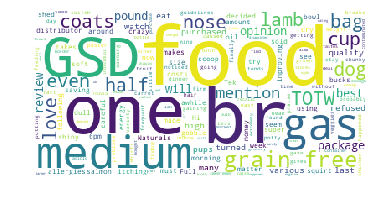

The wordcloud for cluster 1


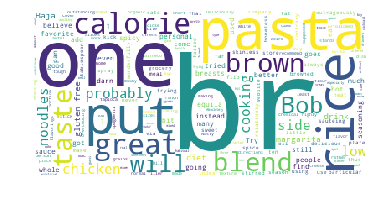

In [116]:
from wordcloud import WordCloud, STOPWORDS


for i in range(2):
    d_ = []
    for j in range(4):
        d1 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[i][j]]['Text']
        d_.append(d1)
    wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(d_))
    print('The wordcloud for cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()       

** Summary **
* Cluster 0's wordcloud shows many animal names like dog, cat and even lambs. Also grain free food is mentioned. So it seem this cluster is based on pets/animals.
* Cluster 1 has normal food items like rice, pasta, chicken etc also brown and chocolates. Also calories, sauces and chinese food like noodles was mentioned too.

# 5 clusters

In [117]:
labeled_data = fin

# k = 5

aggl = AgglomerativeClustering(n_clusters=5)
aggl.fit(sent_vectors)
labeled_data['Cluster_labels'] = aggl.labels_

In [118]:
labeled_data.groupby(['Cluster_labels']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
Cluster_labels                                                               
0               1749       1749    1749         1749                  1749   
1               1143       1143    1143         1143                  1143   
2                356        356     356          356                   356   
3                992        992     992          992                   992   
4                760        760     760          760                   760   

                HelpfulnessDenominator  Score  Time  Summary  Text  \
Cluster_labels                                                       
0                                 1749   1749  1749     1749  1749   
1                                 1143   1143  1143     1143  1143   
2                                  356    356   356      356   356   
3                                  992    992   992      992   992   
4                                  760    760   760      760   760   

                CleanedText  cluster_label  
Cluster_labels                              
0                      1749           1749  
1                      1143           1143  
2                       356            356  
3                       992            992  
4                       760            760

The wordcloud for cluster 0


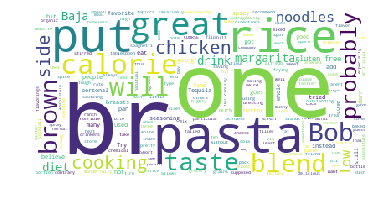

The wordcloud for cluster 1


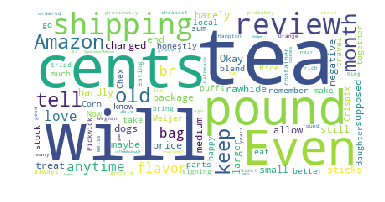

The wordcloud for cluster 2


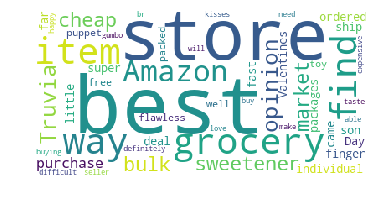

The wordcloud for cluster 3


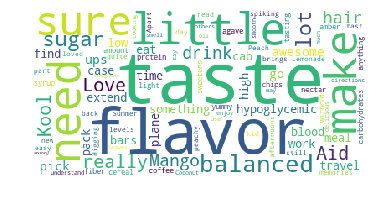

The wordcloud for cluster 4


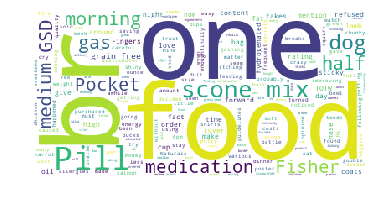

In [119]:
from wordcloud import WordCloud, STOPWORDS


for i in range(5):
    d_ = []
    for j in range(4):
        d1 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[i][j]]['Text']
        d_.append(d1)
    wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(d_))
    print('The wordcloud for cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()       

** Summary **
* Cluster 0 It has basically mainstream food products like pasta, rice, chicken etc. Also brown and chocolates.
* Cluster 1 suggests involvement of shipping costs and other costs, so basically money in different forms of currency.
* Cluster 2 has some items like sweeteners, grocery but basically about stores.
* Cluster 3 balance of taste and flavors etc.
* Cluster 4 looks like medication. Also the word 'dog' is mentioned so maybe for animals too.

### [3.2.3.2] TF-IDF Weighted W2V

In [123]:
tfidf_feat = tfidf_vect.get_feature_names()

tfidf_sent_vectors = []
row=0
for sent in list_of_sent: 
    sent_vec = np.zeros(200) 
    weight_sum = 0.0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_data[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)
print(tfidf_sent_vectors.shape)

(5000, 200)


# 2 clusters

In [124]:
labeled_data = fin

#k = 2

aggl = AgglomerativeClustering(n_clusters=2)
aggl.fit(tfidf_sent_vectors)
labeled_data['Cluster_labels'] = aggl.labels_

In [125]:
labeled_data.groupby(['Cluster_labels']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
Cluster_labels                                                               
0               2816       2816    2816         2816                  2816   
1               2184       2184    2184         2184                  2184   

                HelpfulnessDenominator  Score  Time  Summary  Text  \
Cluster_labels                                                       
0                                 2816   2816  2816     2816  2816   
1                                 2184   2184  2184     2184  2184   

                CleanedText  cluster_label  
Cluster_labels                              
0                      2816           2816  
1                      2184           2184

The wordcloud for cluster 0


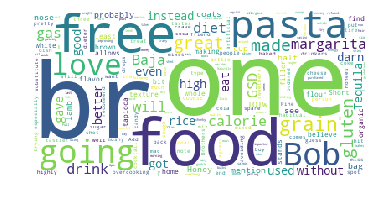

The wordcloud for cluster 1


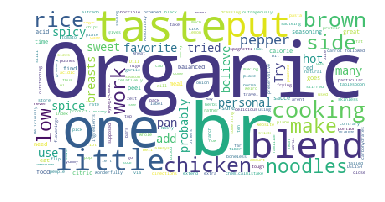

In [126]:
from wordcloud import WordCloud, STOPWORDS


for i in range(2):
    d_ = []
    for j in range(4):
        d1 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[i][j]]['Text']
        d_.append(d1)
    wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(d_))
    print('The wordcloud for cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()       

** Summary **
* Cluster 0 has italian food, drinks(margarita) and the nutrients, grains etc too.
* Cluster 1 by the looks of ir looks like it has chinese food, chicken, sauces etc. Also, brownand chocolate and spicy organic sauce etc.

# 5 Clusters

In [127]:
labeled_data = fin

#k = 5

aggl = AgglomerativeClustering(n_clusters=5)
aggl.fit(tfidf_sent_vectors)
labeled_data['Cluster_labels'] = aggl.labels_

In [128]:
labeled_data.groupby(['Cluster_labels']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
Cluster_labels                                                               
0               1784       1784    1784         1784                  1784   
1               1188       1188    1188         1188                  1188   
2                838        838     838          838                   838   
3                996        996     996          996                   996   
4                194        194     194          194                   194   

                HelpfulnessDenominator  Score  Time  Summary  Text  \
Cluster_labels                                                       
0                                 1784   1784  1784     1784  1784   
1                                 1188   1188  1188     1188  1188   
2                                  838    838   838      838   838   
3                                  996    996   996      996   996   
4                                  194    194   194      194   194   

                CleanedText  cluster_label  
Cluster_labels                              
0                      1784           1784  
1                      1188           1188  
2                       838            838  
3                       996            996  
4                       194            194

The wordcloud for cluster 0


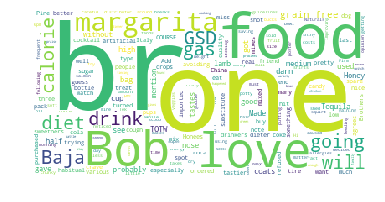

The wordcloud for cluster 1


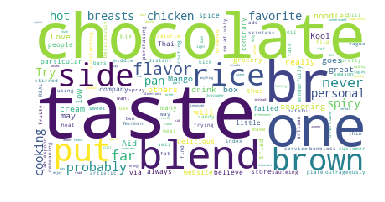

The wordcloud for cluster 2


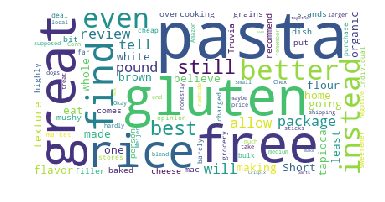

The wordcloud for cluster 3


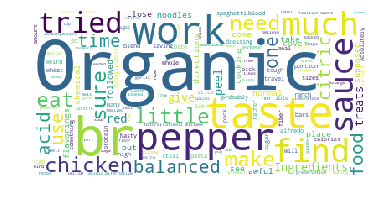

The wordcloud for cluster 4


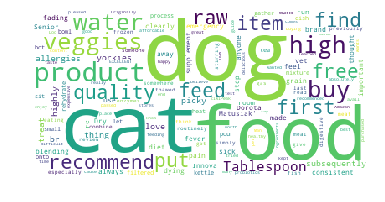

In [129]:
from wordcloud import WordCloud, STOPWORDS


for i in range(5):
    d_ = []
    for j in range(4):
        d1 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[i][j]]['Text']
        d_.append(d1)
    wordcloud = WordCloud(background_color='white',
                          stopwords = set(STOPWORDS)
                      ).generate(str(d_))
    print('The wordcloud for cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()       

** Summary **
* Cluster 0 is about drinks and food items that people mention they love in their reviews.
* Cluster 1 suggests color brown and cholocate nothing much other stuff to make out of it.
* Cluster 2 has healthy food stuff like gluten free stuff, rice etc.
* Cluster 3 looks like it talks about sauces with words like sauce, organic, balanced, chicken, acid, citric etc.
* Cluster 4 appears to contains reviews that mention stuff about there pets.

## [3.3] Density Based Clustering [DBSCAN]

In [25]:
from sklearn.cluster import DBSCAN
data = final_.sample(n=5000)

### [3.3.1] W2V

In [26]:
import gensim
list_of_sent=[]

for sent in data['CleanedText']:
    filtered_sentence=[]
    for word in sent.split():
        for cleaned_words in cleanpunc(word).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [27]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=4)

In [28]:
w2v_words = list(w2v_model.wv.vocab)

### [3.3.1] Avg W2V

In [12]:
sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(100)
    cnt_words = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

(5000, 100)

In [12]:
minPts = 2 * 100  # minimum points = 2 * dimension
# Lower bound function copied from -> https://gist.github.com/m00nlight/0f9306b4d4e61ba0195f
def lower_bound(nums, target): # This function return the number in the array just greater than or equal to itself.
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

#https://github.com/Prakhar-FF13/Amazon-Fine-Food-Reviews
def neighbour_200(x, data): # Returns the distance of 200th nearest neighbour.
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) # computing distances.
        if(len(dists) == 200 and dists[199] > dist): # If distance is larger than current largest distance found.
            l = int(lower_bound(dists, dist)) # Using the lower bound function to get the right position.
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[199] # Dist 199 contains the distance of 200th nearest neighbour.

In [139]:
twohundrethneigh = []
for val in sent_vectors:
    twohundrethneigh.append(neighbour_200(val, sent_vectors) )
twohundrethneigh.sort()

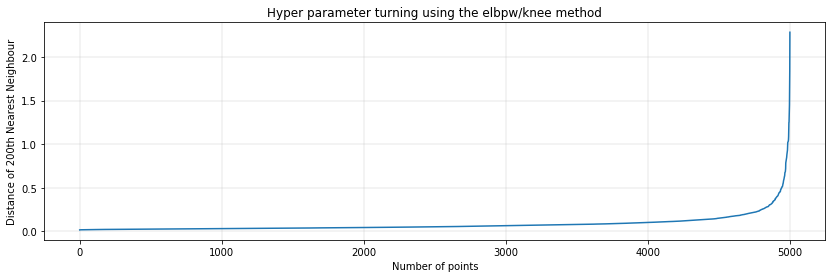

In [140]:
plt.figure(figsize=(14,4))
plt.title("Hyper parameter turning using the elbpw/knee method")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.grid(b=True, linewidth=0.3)
plt.show()

It appears that the elbow point lies somewhere near 0.3. Hence, lets create clusters using eps = 0.3 and min_pts=200

In [14]:
labeled_data = data

model = DBSCAN(eps=0.3, min_samples=200, n_jobs=-1)
model.fit(sent_vectors)
labeled_data['Cluster_labels'] = model.labels_

In [15]:
labeled_data.groupby(['Cluster_labels']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
Cluster_labels                                                               
-1               166        166     166          166                   166   
 0              4834       4834    4834         4834                  4834   

                HelpfulnessDenominator  Score  Time  Summary  Text  \
Cluster_labels                                                       
-1                                 166    166   166      166   166   
 0                                4834   4834  4834     4834  4834   

                CleanedText  
Cluster_labels               
-1                      166  
 0                     4834

The wordcloud for cluster 0


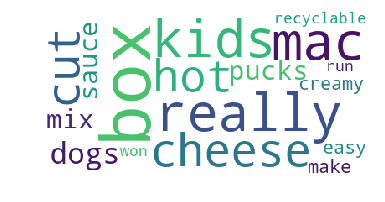

The wordcloud for noisy points


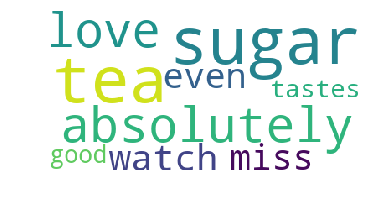

In [32]:
from wordcloud import WordCloud, STOPWORDS

for i in range(4):
    d_ = []
    d1 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[0][i]]['Text']
    d_.append(d1)    
wordcloud = WordCloud(background_color='white', stopwords = set(STOPWORDS)).generate(str(d_))
print('The wordcloud for cluster 0')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

for i in range(4):
    d2_ = []
    d2 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[-1][i]]['Text']
    d2_.append(d2)
wordcloud = WordCloud(background_color='white', stopwords = set(STOPWORDS)).generate(str(d2_))
print('The wordcloud for noisy points')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

** Summary **
* The core points are contained in the cluster 0 so it has all the reviews that have have atleast 200 points in their radius, eps = 0.3. So, this is a little difficult to summarize.
* On the other hand, we see the noise points' wordcloud and that gives us no information at all as the words are not at all related.

### [3.3.2] TF-IDF weighted W2V

In [29]:
tfidf_feat = tfidf_vect.get_feature_names()

tfidf_sent_vectors = []
row=0
for sent in list_of_sent: 
    sent_vec = np.zeros(100) 
    weight_sum = 0.0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_data[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)
print(tfidf_sent_vectors.shape)

C:\Users\chauh\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


(5000, 100)


In [14]:
 twohundrethneigh = []
for val in tfidf_sent_vectors:
    twohundrethneigh.append(neighbour_200(val, tfidf_sent_vectors) )
twohundrethneigh.sort()

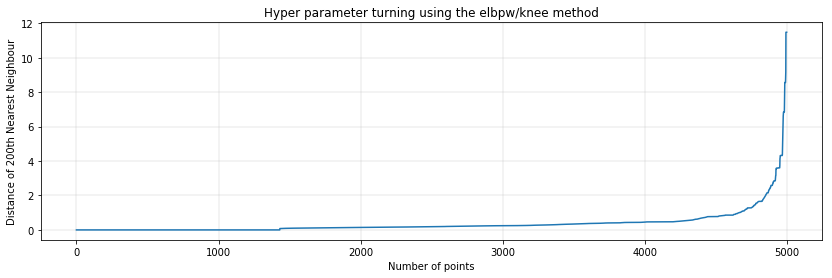

In [15]:
plt.figure(figsize=(14,4))
plt.title("Hyper parameter turning using the elbpw/knee method")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.grid(b=True, linewidth=0.3)
plt.show()

Observing the above plot it could be seen that the knee point lies somewhere near 1, hence lets create clusters using eps =  1 and min_pts = 200

In [30]:
labeled_data = data

model = DBSCAN(eps=1, min_samples=200, n_jobs=-1)
model.fit(tfidf_sent_vectors)
labeled_data['Cluster_labels'] = model.labels_

In [31]:
labeled_data.groupby(['Cluster_labels']).count()

Id  ProductId  UserId  ProfileName  HelpfulnessNumerator  \
Cluster_labels                                                               
-1                82         82      82           82                    82   
 0              1433       1433    1433         1433                  1433   
 1              3485       3485    3485         3485                  3485   

                HelpfulnessDenominator  Score  Time  Summary  Text  \
Cluster_labels                                                       
-1                                  82     82    82       82    82   
 0                                1433   1433  1433     1433  1433   
 1                                3485   3485  3485     3485  3485   

                CleanedText  
Cluster_labels               
-1                       82  
 0                     1433  
 1                     3485

The wordcloud for cluster 0


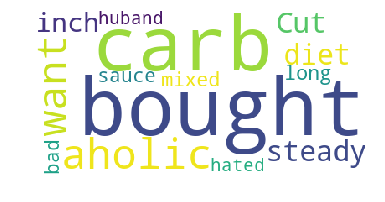

The wordcloud for cluster 1


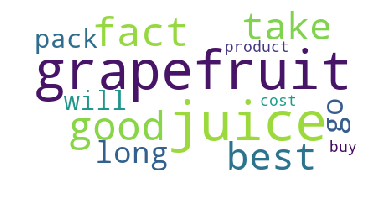

The wordcloud for noise points


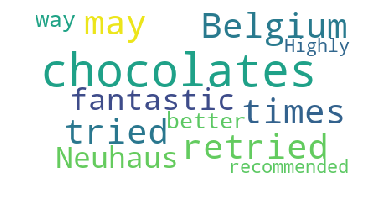

In [33]:
from wordcloud import WordCloud, STOPWORDS

for i in range(4):
    d_ = []
    d1 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[0][i]]['Text']
    d_.append(d1)
wordcloud = WordCloud(background_color='white', stopwords = set(STOPWORDS)).generate(str(d_))
print('The wordcloud for cluster 0')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

for i in range(4):
    d_ = []
    d1 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[1][i]]['Text']
    d_.append(d1)
wordcloud = WordCloud(background_color='white', stopwords = set(STOPWORDS)).generate(str(d_))
print('The wordcloud for cluster 1')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

for i in range(4):
    d_ = []
    d1 = labeled_data.loc[labeled_data.groupby(['Cluster_labels']).groups[-1][i]]['Text']
    d_.append(d1)
wordcloud = WordCloud(background_color='white', stopwords = set(STOPWORDS)).generate(str(d_))
print('The wordcloud for noise points')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

** Summary **

Two cluster were created:

* Cluster 0 contains carbohydrates and by the look of it alcohol and other liquid stuff.
* Cluster 1 looks like it contains juices and stuff
* Cluster -1 contains the noisy points

# Conclusion

* K-means clustering yielded 10 clusters while using elbow/knee method to tune the hyperparameter, that is the number of clusters, for each of the 4 vectorizations.
* for Agglomerative clustering, for each vectorization, 2 and 5 clusters were formed and interpretations were made.
* finally, the clusters were created using density based clustering, DBSCAN and the parameter(eps) was tuned by using the elbow/knee method and found for Avg W2V and Tfidf W2V.